## XLM-Roberta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow import keras
import nltk
import warnings
warnings.filterwarnings('ignore')
import random
from transformers import AutoTokenizer, TFAutoModel, AutoModelWithLMHead
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

#### Dataset

In [ ]:
train1 = pd.read_csv("C:/Users/25529/Downloads/jigsaw/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("C:/Users/25529/Downloads/jigsaw/jigsaw-unintended-bias-train.csv")
test = pd.read_csv('C:/Users/25529/Downloads/jigsaw/validation.csv')

<AxesSubplot:xlabel='toxic', ylabel='count'>

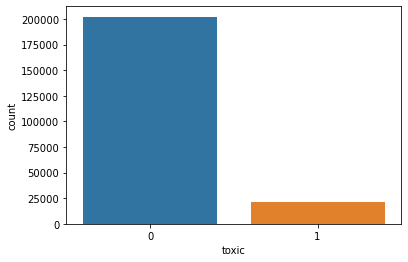

In [ ]:
sns.countplot(train1['toxic'])

In [ ]:
train1 = pd.concat([train1[['comment_text', 'toxic']].query('toxic == 0').sample(90000, random_state = 101),
                   train1[['comment_text', 'toxic']].query('toxic == 1')])
train1.shape

(111384, 2)

<AxesSubplot:xlabel='toxic', ylabel='count'>

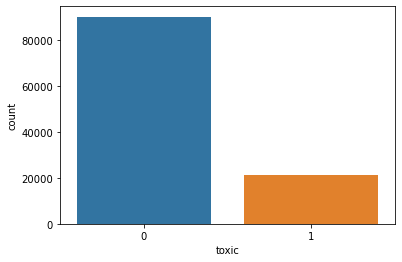

In [ ]:
sns.countplot(train1['toxic'])

In [ ]:
train2.loc[train2['toxic']>=0.7, 'toxic'] = 1
train = pd.concat([train1, train2[['comment_text', 'toxic']].query('toxic == 1')])
train.shape

(173247, 2)

<AxesSubplot:xlabel='toxic', ylabel='count'>

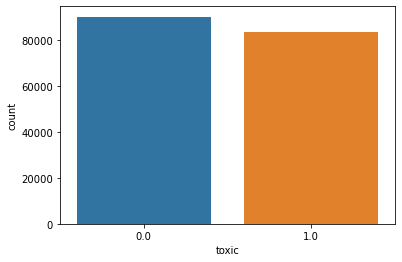

In [ ]:
sns.countplot(train['toxic'])

<AxesSubplot:xlabel='toxic', ylabel='count'>

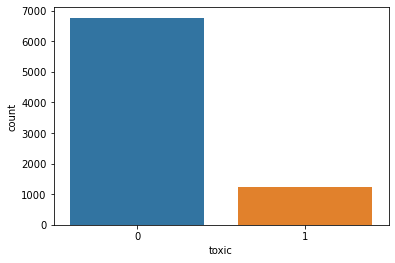

In [ ]:
sns.countplot(test['toxic'])

<AxesSubplot:xlabel='lang', ylabel='count'>

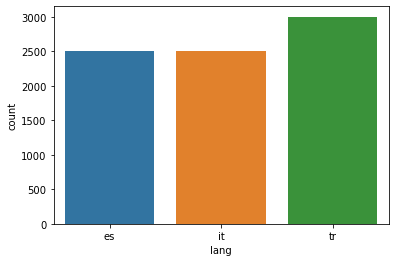

In [ ]:
sns.countplot(test['lang'])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-large")

In [ ]:
MAX_LEN = 66
def preprocess(data, max_seq_length = MAX_LEN, tokenizer = tokenizer):    
    ids = []
    masks = []
    segment = []
    for i in tqdm(range(len(data))):
        
        tokens = tokenizer.tokenize(data[i])
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[ : max_seq_length - 2]

        # Converting tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])
        # Added [CLS] and [SEP] as required to BERT Model

        # Input mask
        input_masks = [1] * len(input_ids)

        # padding upto max length
        padding = max_seq_length - len(input_ids)
        input_ids.extend([0] * padding)
        input_masks.extend([0] * padding)
        segment_ids =[0]* max_seq_length
        
        
        ids.append(input_ids)
        masks.append(input_masks)
        segment.append(segment_ids)
    
    return (np.array(ids), np.array(masks), np.array(segment))

In [ ]:
train_ids, train_masks, train_segment =  preprocess(train["comment_text"].values)
test_ids, test_masks, test_segment =  preprocess(test["comment_text"].values)
y_train = train['toxic'].values
y_test = test['toxic'].values

  0%|          | 0/173247 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

#### model

In [ ]:
BATCH_SIZE = 4

def model(roberta_layer, max_len = MAX_LEN):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = roberta_layer([input_word_ids, input_mask, segment_ids])

    # There are two outputs: a pooled_output of shape [batch_size, 768] with representations for 
    # the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] 
    # with representations for each input token (in context)


    x = pooled_output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = x)
    
    return model

In [ ]:
roberta_layer = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large", trainable = True)
model = model(roberta_layer)
model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
skf = StratifiedKFold(n_splits = 4, shuffle = True)
skf.get_n_splits(train_ids, y_train)
skf

#### train

In [ ]:
i = 1
preds = []
for train_index, test_index in skf.split(train_ids, y_train):
    print("\n")
    print("#" * 20)
    print(f"FOLD No {i}")
    print("#" * 20)
    
    
    tr_ids = train_ids[train_index]
    tr_masks = train_masks[train_index]
    tr_segment = train_segment[train_index]
    
    vd_ids = train_ids[test_index]
    vd_masks = train_masks[test_index]
    vd_segment = train_segment[test_index]
    
    y_tr = y_train[train_index]
    y_vd = y_train[test_index]
    
    
    history = model.fit(
    (tr_ids, tr_masks, tr_segment), y_tr,epochs=2,batch_size=BATCH_SIZE,validation_data = ((vd_ids, vd_masks, vd_segment), y_vd),
    steps_per_epoch = len(tr_ids)//BATCH_SIZE)

    predictions = model.predict((test_ids, test_masks, test_segment))
    preds.append(predictions)
    
    i += 1
    K.clear_session()

In [ ]:
predictions =  0.25*preds[0] + 0.25*preds[1] + 0.25*preds[2] + 0.25*preds[3]

## 最终结果 
#### test_accuracy:0.861625
#### test_f1:0.5570228091236494